## Description
This notebook examines response time (time it takes for exchanges to submit bids).

In [1]:
## Set auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
import os

from google.cloud import bigquery
from google.cloud import bigquery_storage
import matplotlib.pyplot as plt
import numpy as np

from utils import get_bigquery_result

%matplotlib inline

In [3]:
GCP_PROJECT = "ox-datascience-devint"

In [4]:
""" Load the data """
sql = open("sql/latency_query.sql", "r").read()
filepath = "input/latency_data.csv"

df = get_bigquery_result(sql, filepath=filepath, gcp_project=GCP_PROJECT)
display(df.head())

,bidderTimeout,bid_value,latency,win
0,1500,-1,-1,False
1,1500,304569,619,False
2,1500,22078989,368,True
3,1500,272008,668,False
4,1500,252182,742,False


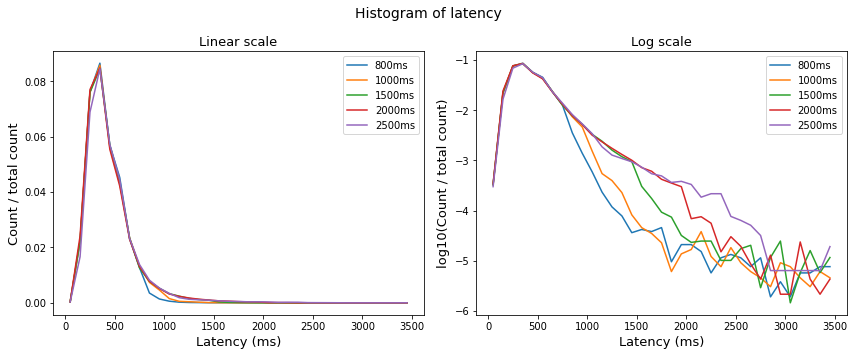

In [5]:
""" Plot and save latency data grouped by timeout """
max_latency = 3500
timeouts = [800, 1000, 1500, 2000, 2500]
publisher_name = "lainey_gossip"

bins = np.linspace(0, max_latency, 36) 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
for timeout in timeouts:

    sub_df = df[df["bidderTimeout"] == timeout]

    u, v = np.histogram(sub_df["latency"], bins=bins)

    x = (v[1:] + v[:-1]) / 2
    y = u / len(sub_df)

    axs[0].plot(x, y, label=f"{timeout}ms")
    axs[1].plot(x, np.log10(1/len(sub_df)+y), label=f"{timeout}ms")

axs[0].legend()
axs[1].legend()

axs[0].set_title("Linear scale", fontsize=13)
axs[1].set_title("Log scale", fontsize=13)

axs[0].set_xlabel("Latency (ms)", fontsize=13)
axs[1].set_xlabel("Latency (ms)", fontsize=13)
axs[0].set_ylabel("Count / total count", fontsize=13)
axs[1].set_ylabel("log10(Count / total count)", fontsize=13)

fig.suptitle("Histogram of latency", fontsize=14)

fig.tight_layout()

if not os.path.exists("output/"):
    os.mkdir("output")
fig.savefig(f"output/latency_histogram_timeouts.png", dpi=150)

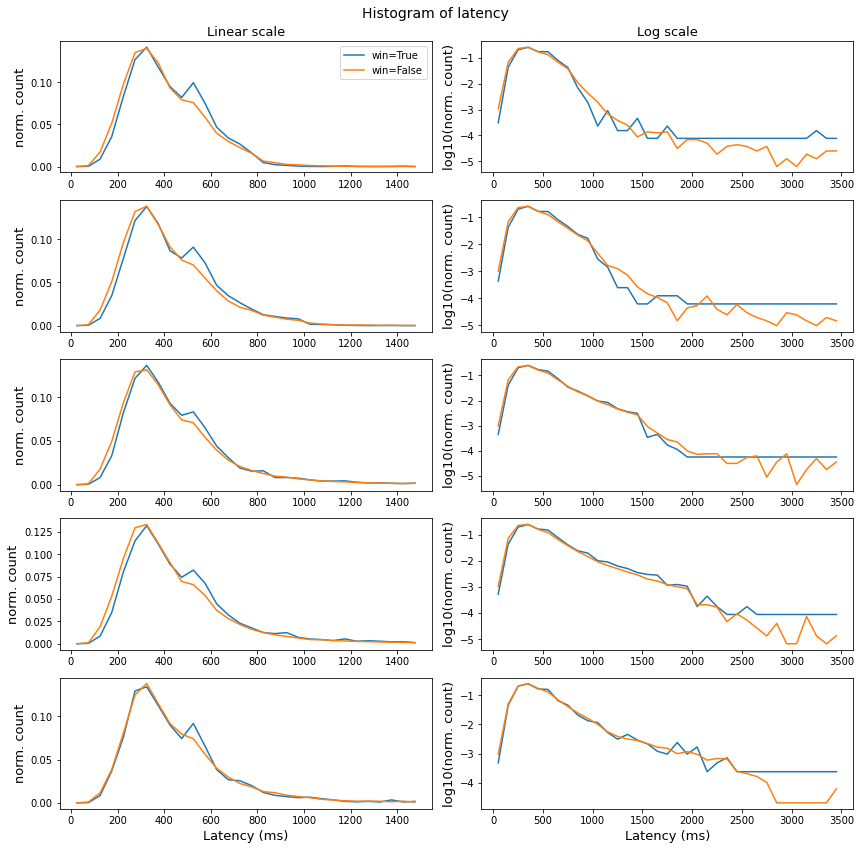

In [6]:
""" Plot and save latency data grouped by win and timeout """
timeouts = [800, 1000, 1500, 2000, 2500]
publisher_name = "lainey_gossip"

fig, axes = plt.subplots(5, 2, figsize=(12, 12))
for idx, timeout in enumerate(timeouts):
    ax = axes[idx]
    for win in [True, False]:

        sub_df = df[df["bidderTimeout"] == timeout]
        sub_df = sub_df[sub_df["win"] == win]

        sub_df = sub_df[sub_df["latency"] > 0]

        u, v = np.histogram(sub_df["latency"], bins=np.linspace(0, 1500, 31))

        x = (v[1:] + v[:-1]) / 2
        y = u / len(sub_df)

        ax[0].plot(x, y, label=f"win={win}")

        u, v = np.histogram(sub_df["latency"], bins=np.linspace(0, 3500, 36))

        x = (v[1:] + v[:-1]) / 2
        y = u / len(sub_df)

        ax[1].plot(x, np.log10(1/len(sub_df)+y), label=f"win={win}")

    ax[0].set_ylabel("norm. count", fontsize=13)
    ax[1].set_ylabel("log10(norm. count)", fontsize=13)

axes[0,0].legend()
axes[0,0].set_title("Linear scale", fontsize=13)
axes[0,1].set_title("Log scale", fontsize=13)
axes[-1,0].set_xlabel("Latency (ms)", fontsize=13)
axes[-1,1].set_xlabel("Latency (ms)", fontsize=13)
    
fig.suptitle(f"Histogram of latency", fontsize=14)

fig.tight_layout()

if not os.path.exists("output/"):
    os.mkdir("output")
fig.savefig(f"output/latency_histogram_wins.png", dpi=150)

In [7]:
""" Calculate null rate (no response/bid) """
for timeout in timeouts:
    sub_df = df[df["bidderTimeout"] == timeout]
    null_rate = round( len(sub_df[sub_df["latency"] == -1] ) / len(sub_df), 4)
    print(f"timeout = {timeout}ms,\tnull_rate = {null_rate}")

timeout = 800ms,	null_rate = 0.6709
timeout = 1000ms,	null_rate = 0.6645
timeout = 1500ms,	null_rate = 0.657
timeout = 2000ms,	null_rate = 0.6549
timeout = 2500ms,	null_rate = 0.6652
